In [1]:
include("model.jl")
include("Parser.jl")
include("greedy.jl")
include("utils.jl")
using JuMP
using HiGHS

In [2]:
files = readdir("Instances")
println(files)

["coord100-10-1_processed.dat", "coord100-10-1b_processed.dat", "coord100-10-2_processed.dat", "coord100-10-2b_processed.dat", "coord100-10-3_processed.dat", "coord100-10-3b_processed.dat", "coord100-5-1_processed.dat", "coord100-5-1b_processed.dat", "coord100-5-2_processed.dat", "coord100-5-2b_processed.dat", "coord100-5-3_processed.dat", "coord100-5-3b_processed.dat", "coord20-5-1_processed.dat", "coord20-5-1b_processed.dat", "coord20-5-2_processed.dat", "coord20-5-2b_processed.dat", "coord200-10-1_processed.dat", "coord200-10-1b_processed.dat", "coord200-10-2_processed.dat", "coord200-10-2b_processed.dat", "coord200-10-3_processed.dat", "coord200-10-3b_processed.dat", "coord50-5-1_processed.dat", "coord50-5-1b_processed.dat", "coord50-5-2BIS_processed.dat", "coord50-5-2_processed.dat", "coord50-5-2bBIS_processed.dat", "coord50-5-2b_processed.dat", "coord50-5-3_processed.dat", "coord50-5-3b_processed.dat"]


## Data processing

In [3]:
n, m, x_VC, y_VC, x_loc, y_loc, Q, C, q, f, p, tc, B, R, localities_with_high_priorities, M = parse_instance("./Instances/coord20-5-2_processed.dat")

(20, 5, [6.0, 10.0, 47.0, 18.0, 31.0], [21.0, 1.0, 15.0, 25.0, 42.0], [9.0, 22.0, 8.0, 2.0, 20.0, 2.0, 25.0, 20.0, 15.0, 4.0, 29.0, 34.0, 27.0, 46.0, 33.0, 28.0, 44.0, 33.0, 35.0, 40.0], [22.0, 5.0, 17.0, 22.0, 29.0, 24.0, 15.0, 24.0, 2.0, 18.0, 47.0, 25.0, 39.0, 33.0, 29.0, 46.0, 28.0, 32.0, 23.0, 39.0], 70, [70, 140, 70, 140, 140], [20, 11, 18, 13, 12, 17, 19, 13, 18, 14, 12, 15, 15, 20, 13, 14, 17, 19, 14, 16], [9576, 8149, 14050, 8004, 6616], 1000, 0, 10769.655012070602, [11.579684512642148, 13.40113471167733, 9.764853467462618, 8.065311473886684, 11.424395537122809], [17, 2, 4], 5)

In [4]:
println("Budget: ", B)
println("Q = ", Q)
println("C = ", C)
println("M = ", M)

Budget: 10769.655012070602
Q = 70
C = [70, 140, 70, 140, 140]
M = 5


In [5]:
# Create the distance matrix
distance_matrix = zeros(Float64, m, n)

for i in 1:m 
    for j in 1:n
        distance_matrix[i, j] = sqrt((x_VC[i] - x_loc[j])^2 + (y_VC[i] - y_loc[j])^2)
    end
end


# Create reachability matrix a
A = zeros(Int, m, n)


for i in 1:m
    for j in 1:n
        if distance_matrix[i, j] <= R[i]
            A[i, j] = 1
        end
    end
end

In [6]:
D = zeros(Float64, n+m, n+m)
#The n first rows/cols of D relate to the localities, the m last to the VC
#In other words, calling D[i,j] for i in I, j in J corresponds to call D[i+n,j]
for i in 1:m+n
    for j in 1:m+n
        if i <= n && j <= n
            # Both indices in `loc`
            D[i, j] = sqrt((x_loc[i] - x_loc[j])^2 + (y_loc[i] - y_loc[j])^2)
        elseif i > n && j > n
            # Both indices in `VC`
            D[i, j] = sqrt((x_VC[i - n] - x_VC[j - n])^2 + (y_VC[i - n] - y_VC[j - n])^2)
        elseif i > n && j <= n
            # i in `VC`, j in `loc`
            D[i, j] = sqrt((x_VC[i - n] - x_loc[j])^2 + (y_VC[i - n] - y_loc[j])^2)
        else
            # i in `loc`, j in `VC`
            D[i, j] = sqrt((x_loc[i] - x_VC[j - n])^2 + (y_loc[i] - y_VC[j - n])^2)
        end
    end
end

## Greedy Algorithm

In [7]:
VC, MMTs, Budget, Q_MMTs, Q_tot = greedy_OptVax(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)


(5, [[(25, 25), (25, 17), (17, 2), (2, 4), (4, 6), (6, 5), (5, 25)], [(25, 25), (25, 1), (1, 3), (3, 10), (10, 9), (9, 25)]], 8645.732137494637, [70, 70], 140)

In [8]:
new_MMTs = local_search_2Opt(MMTs, D)

2-element Vector{Vector{Tuple{Int64, Int64}}}:
 [(25, 25), (25, 17), (17, 2), (2, 4), (4, 6), (6, 5), (5, 25)]
 [(25, 25), (25, 1), (1, 10), (10, 3), (3, 9), (9, 25)]

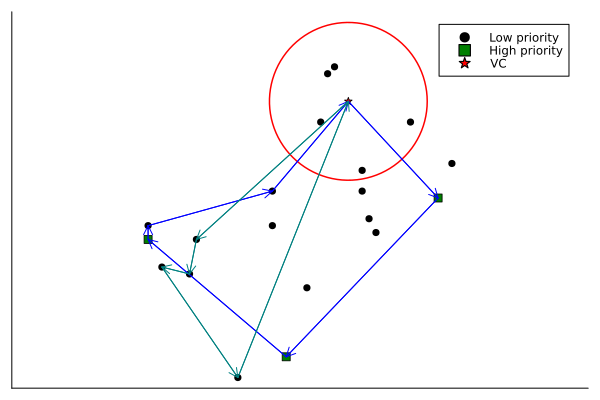

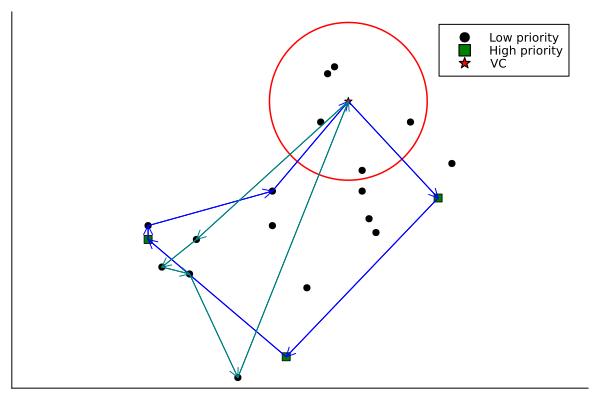

In [9]:
plot_solution_greedy(MMTs, x_VC, y_VC, x_loc, y_loc, R, n, m, M, localities_with_high_priorities)
plot_solution_greedy(new_MMTs, x_VC, y_VC, x_loc, y_loc, R, n, m, M, localities_with_high_priorities)

## Models Creation

### OptVax1

In [ ]:
model_OptVax1 = solve_OptVax1(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)
greedy_init(model_OptVax1, new_MMTs, VC, M, n, m, q)
optimize!(model_OptVax1)    

obj_val = objective_value(model_OptVax1)
println("Objective Value: ", obj_val)

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+04]
  Cost   [1e+01, 2e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+04]
Presolving model
5355 rows, 3129 cols, 28046 nonzeros  0s
5075 rows, 1883 cols, 18767 nonzeros  0s
2983 rows, 1876 cols, 16297 nonzeros  0s
2834 rows, 1814 cols, 13558 nonzeros  0s
Objective function is integral with scale 1

Solving MIP model with:
   2834 rows
   1814 cols (1794 binary, 20 integer, 0 implied int., 0 continuous)
   13558 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   460             -inf                 inf        0      0      0         0     0.5s
         0       0         0   0.00%   216             -inf               

### OptVax2

In [11]:
# model_OptVax2 = solve_OptVax2(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)
# greedy_init(model_OptVax2, MMTs, VC, M, n, m, q)
# optimize!(model_OptVax2)


# obj_val = objective_value(model_OptVax2)
# println("Objective Value: ", obj_val)

### OptVax2LP

In [12]:
# model_OptVax2LP = solve_OptVax2LP(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)
# greedy_init(model_OptVax2LP, MMTs, VC, M, n, m, q)
# optimize!(model_OptVax2LP)


# obj_val = objective_value(model_OptVax2LP)
# println("Objective Value: ", obj_val)

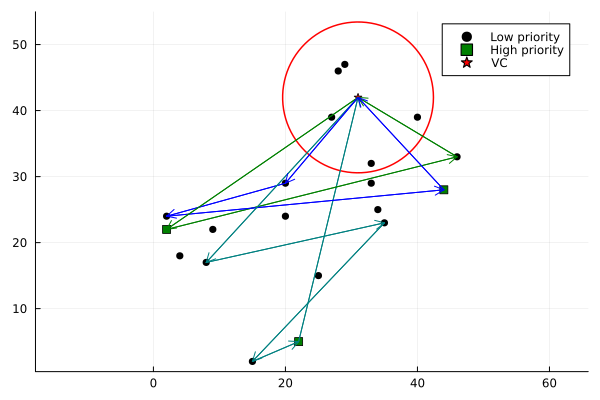

In [15]:
plot_solution(model_OptVax1, x_VC, y_VC, x_loc, y_loc, R,n,m,M, localities_with_high_priorities)